# Restaurant Recommendation System

## Notebook by [Wenyi Xu]("https://github.com/xuwenyihust")

### My own solution to Harvard CS 109 HW4
<br/>
### Import libraries & some preparation works

In [10]:
%matplotlib inline
from collections import defaultdict
import json

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd

from matplotlib import rcParams
import matplotlib.cm as cm
import matplotlib as mpl

#colorbrewer2 Dark2 qualitative color table
dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843)]

rcParams['figure.figsize'] = (10, 6)
rcParams['figure.dpi'] = 150
#rcParams['axes.prop_cycle'] = dark2_colors
rcParams['lines.linewidth'] = 2
rcParams['axes.facecolor'] = 'white'
rcParams['font.size'] = 14
rcParams['patch.edgecolor'] = 'white'
rcParams['patch.facecolor'] = dark2_colors[0]
rcParams['font.family'] = 'StixGeneral'


def remove_border(axes=None, top=False, right=False, left=True, bottom=True):
    """
    Minimize chartjunk by stripping out unnecesasry plot borders and axis ticks
    
    The top/right/left/bottom keywords toggle whether the corresponding plot border is drawn
    """
    ax = axes or plt.gca()
    ax.spines['top'].set_visible(top)
    ax.spines['right'].set_visible(right)
    ax.spines['left'].set_visible(left)
    ax.spines['bottom'].set_visible(bottom)
    
    #turn off all ticks
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    
    #now re-enable visibles
    if top:
        ax.xaxis.tick_top()
    if bottom:
        ax.xaxis.tick_bottom()
    if left:
        ax.yaxis.tick_left()
    if right:
        ax.yaxis.tick_right()
        
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)

### Load the dataset

In [9]:
fulldf=pd.read_csv("https://raw.githubusercontent.com/xuwenyihust/Restaurant-Recommendation-System/master/bigdf.csv")
fulldf.head(2)

,user_id,business_id,date,review_id,stars,usefulvotes_review,user_name,categories,biz_name,latitude,longitude,business_avg,business_review_count,user_avg,user_review_count
0,rLtl8ZkDX5vH5nAx9C3q5Q,9yKzy9PApeiPPOUJEtnvkg,2011-01-26 00:00:00,fWKvX83p0-ka4JS3dc6E5A,5,5,Jason,"[Breakfast & Brunch, Restaurants]",Morning Glory Cafe,33.390792,-112.012504,3.87156,109,3.796954,197
1,SBbftLzfYYKItOMFwOTIJg,9yKzy9PApeiPPOUJEtnvkg,2008-05-04 00:00:00,DASdFe-g0BgfN9J2tanStg,5,1,Jennifer,"[Breakfast & Brunch, Restaurants]",Morning Glory Cafe,33.390792,-112.012504,3.87156,109,3.473684,57


## Q1. Writing a simple "global" recommender

Assume that every users perceive the similarity between items in the same way. (**global similarity** instead of user-specific similarity)

Calculate the similarity between items by their entire common user support.

**common user support:** use the set of common raters of both items to measure the similarity between items.
<br/>
<br/>
### Exploratory Data Analysis

**1.1** Visualize the sparsity of the full data set by plotting two histograms of the review count grouped by the user_id and business_id respectively. Are there more users or more businesses?

We can see from the plots that users with 0~3 reviews are the most,

and that businesses with 0~5 reviews are the most.

<br/>

user_id
--65q1FpAL_UQtVZ2PTGew    108
--AqBuo717RyacADExYbSA      1
--LzFD0UDbYE-Oho3AhsOg      1
--M-cIkGnH1KhnLaCOmoPQ      1
--RD0Z_F0tV4L-AzhOzXYA      1
Name: review_id, dtype: int64


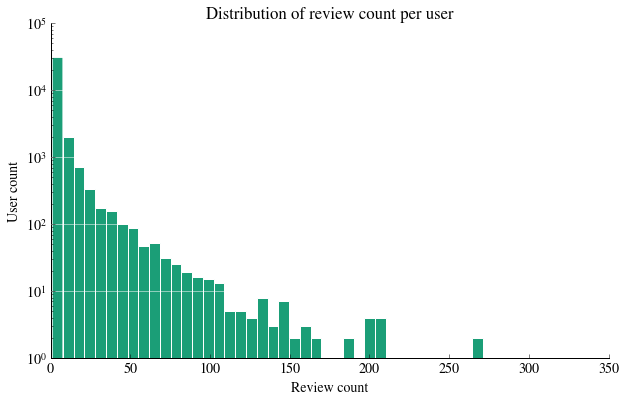

In [38]:
# Number of review_ids for each user_id
review_per_user = fulldf.groupby(["user_id"])["review_id"].count()
print(review_per_user[:5])

bin_cnt = len(set(review_per_user.tolist()))

fig, ax = plt.subplots()
ax.set(xlabel="Review count", ylabel="User count", title="Distribution of review count per user")
remove_border(ax)
#ax.axis('off')
plt.hist(review_per_user, bins=int(bin_cnt/3), log=True)
plt.grid(False)
plt.grid(axis = 'y', color ='white', linestyle='-')
plt.show()

business_id
--5jkZ3-nUPZxUvtcbr8Uw    11
--BlvDO_RG2yElKu9XA1_g    36
-0QBrNvhrPQCaeo7mTo0zQ     3
-0bUDim5OGuv8R0Qqq6J4A     6
-1bOb2izeJBZjHC7NWxiPA    47
Name: review_id, dtype: int64


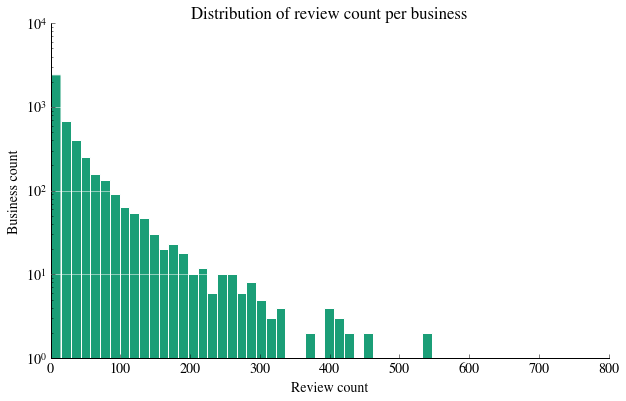

In [41]:
# Number of review_ids for each business_id
review_per_business = fulldf.groupby(["business_id"])["review_id"].count()
print(review_per_business[:5])

bin_cnt = len(set(review_per_business.tolist()))

fig, ax = plt.subplots()
ax.set(xlabel="Review count", ylabel="Business count", title="Distribution of review count per business")
remove_border(ax)
#ax.axis('off')
plt.hist(review_per_business, bins=int(bin_cnt/5), log=True)
plt.grid(False)
plt.grid(axis = 'y', color ='white', linestyle='-')
plt.show()

Compare the number of users & businesses.

In [43]:
user_cnt = len(set(fulldf["user_id"].tolist()))
business_cnt = len(set(fulldf["business_id"].tolist()))
print("More users than businesses.") if user_cnt > business_cnt else print("More users than businesses.")

More users than businesses.


**1.2** Compute the average rating of reviews in the data set and a histogram of all the ratings in the dataset.